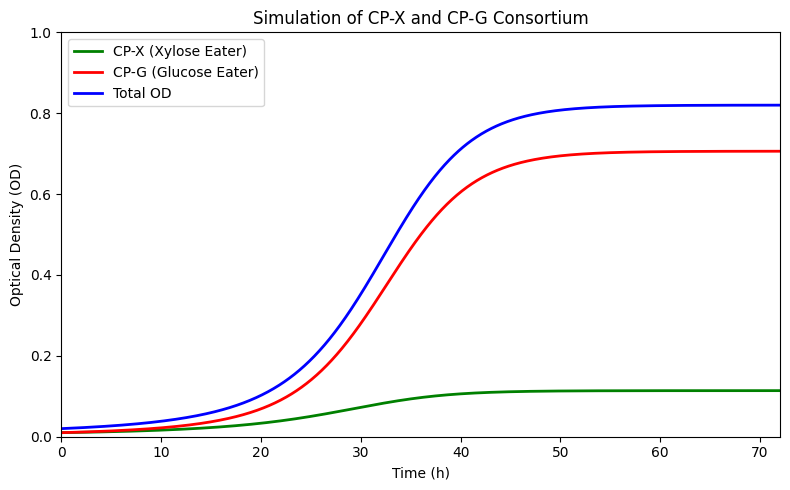

In [17]:
"""
Two-Strain Consortium Model (CP-X and CP-G)

This script simulates the logistic cross-feeding model described in the paper:
"Building a syntrophic Pseudomonas putida consortium with reciprocal substrate 
processing of lignocellulosic disaccharides."

KEY POINTS:
-----------
1. CP-X (Xylose eater) and CP-G (Glucose eater) depend on each other for 
   converting disaccharides (cellobiose and xylobiose) into monosaccharides 
   (glucose, xylose).
2. The model uses two ODEs describing population growth of CP-X (X) and CP-G (Y).
3. Includes a logistic term to account for total carrying capacity, plus 
   adjustable parameters for enzyme expression, substrate ratios, etc.

Author: Jesús Miró-Bueno
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# -----------------------------------------------------------------------------
# MODEL PARAMETERS
# -----------------------------------------------------------------------------
# Below are typical baseline parameter values for the system. You can change them
# to explore different scenarios (e.g., degrade tags, varied substrate ratios).
rmx = 0.12       # Max growth rate for CP-X (Xylose eater)
rmy = 0.34       # Max growth rate for CP-G (Glucose eater)

Cx  = 0.04       # Inverse-proportional factor for BglC (CP-X side)
Cy  = 0.02       # Inverse-proportional factor for Xyl43A (CP-G side)

Dx  = 1.0        # Scaling factor for cellobiose availability
Dy  = 1.0        # Scaling factor for xylobiose availability

Ex  = 1.0        # BglC enzyme expression level in CP-X
Ey  = 1.0        # Xyl43A enzyme expression level in CP-G

# Bx and By are used to encode additional 'burden' scaling
Bx = 1.0 / Ex
By = 1.0 / Ey

# The carrying capacity K is scaled by alpha_K = min(Ex, Dx, Ey, Dy) 
alpha_K = min(Ex, Dx, Ey, Dy)
K       = 0.82 * alpha_K

# -----------------------------------------------------------------------------
# MODEL EQUATIONS
# -----------------------------------------------------------------------------
def model_consortium(X, Y):
    """
    Computes the derivatives dX/dt, dY/dt for the consortium at any time point.
    """
   
    # Growth equations with logistic limitation
    dXdt = (rmx / Bx) * Dy * Y / ((Cy / Ey) + Y) * (1.0 - (X + Y) / K) * X
    dYdt = (rmy / By) * Dx * X / ((Cx / Ex) + X) * (1.0 - (X + Y) / K) * Y
    
    return dXdt, dYdt

def model_EDOS(state, t, model_func):
    """
    Wraps the model function for use with odeint.
    """
    X, Y = state
    dXdt, dYdt = model_func(X, Y)
    return [dXdt, dYdt]

# -----------------------------------------------------------------------------
# ODE INTEGRATION
# -----------------------------------------------------------------------------
def trajectory(initial_conditions, t_max, model_func):
    """
    Integrates the consortium model over the specified time range.
    """
    # Create a time array (0 -> t_max) with 1000 points
    t = np.linspace(0, t_max, 1000)
    
    # Integrate using odeint
    result = odeint(model_EDOS, initial_conditions, t, args=(model_func,))
    
    # Extract columns
    X_traj = result[:, 0]
    Y_traj = result[:, 1]
    
    return X_traj, Y_traj, t

# -----------------------------------------------------------------------------
# SIMULATION & PLOT
# -----------------------------------------------------------------------------

# Choose simulation time
t_max = 72.0  # hours

# Initial conditions (OD) for each strain
X_0 = 0.01
Y_0 = 0.01

initial_conditions = [X_0, Y_0]

# Run the simulation
X_traj, Y_traj, t = trajectory(initial_conditions, t_max, model_consortium)

# Plotting
plt.figure(figsize=(8,5))
plt.plot(t, X_traj, 'g', linewidth=2, label='CP-X (Xylose Eater)')
plt.plot(t, Y_traj, 'r', linewidth=2, label='CP-G (Glucose Eater)')
plt.plot(t, X_traj + Y_traj, 'b', linewidth=2, label='Total OD')

plt.xlabel('Time (h)')
plt.ylabel('Optical Density (OD)')
plt.title('Simulation of CP-X and CP-G Consortium')
plt.legend(loc='best')
plt.xlim([0, t_max])
plt.ylim([0, 1.0])
plt.tight_layout()
plt.show()
